# MIOFlow

## Workflow
1. Load pre-processed SERGIO simulation AnnData
2. Train a **GAGA autoencoder** (`gaga.py`) — learns a geometry-preserving latent embedding from PCA, regularised by PHATE distances
3. Pass the trained GAGA model to `MIOFlow` and call `fit()` — trains a Neural ODE in GAGA latent space using optimal transport
4. Inspect losses and trajectories
5. `decode_to_gene_space()` — maps trajectories back through the GAGA decoder and PCA components to recover gene-level predictions

In [19]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances

sys.path.insert(0, '../MIOFlow')
from gaga import Autoencoder, train_gaga_two_phase, dataloader_from_pc
from mioflow import MIOFlow


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Data

In [20]:
adata = sc.read_h5ad('data/sergio/SERGIO_sim_DS9.h5ad')
adata.obs['merged_pseudotime_bin'] = adata.obs['pseudotime_bin'].copy()
adata.obs['merged_pseudotime_bin'] = adata.obs['merged_pseudotime_bin'].replace({4:3, 5: 3, 6: 3, 7: 3})
adata.obs['merged_pseudotime_bin'] = adata.obs['merged_pseudotime_bin'].astype('category')
adata


AnnData object with n_obs × n_vars = 900 × 100
    obs: 'sim_time_bin', 'sim_timepoint', 'pseudotime', 'pseudotime_bin', 'merged_pseudotime_bin'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'X_phate', 'X_phate_pca'
    varm: 'PCs'

In [21]:
adata.obs['merged_pseudotime_bin'].value_counts()

merged_pseudotime_bin
3    562
0    113
2    113
1    112
Name: count, dtype: int64

Set the time_column for your dataset

In [22]:
time_column = 'merged_pseudotime_bin' #Set the time_column for your dataset

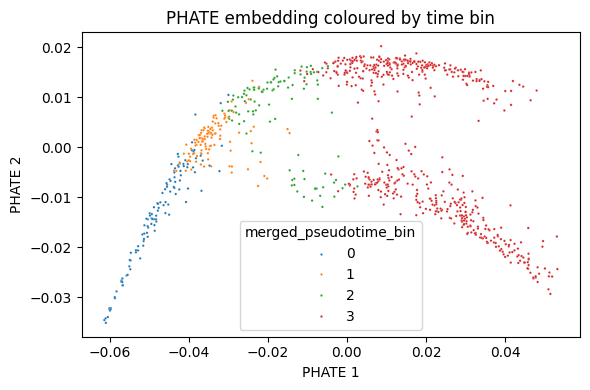

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(
    x=adata.obsm['X_phate'][:, 0],
    y=adata.obsm['X_phate'][:, 1],
    hue=adata.obs[time_column],
    palette='tab10',
    s=3,
    ax=ax,
)
ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')
ax.set_title('PHATE embedding coloured by time bin')
plt.tight_layout()
plt.show()

## 2. Train GAGA Autoencoder

GAGA (`gaga.py`) trains a two-phase autoencoder on PCA embeddings, regularised by PHATE distances:

- **Phase 1** — encoder learns a geometry-preserving latent space (distance preservation loss, decoder frozen)
- **Phase 2** — decoder learns to reconstruct PCA coordinates (reconstruction loss, encoder frozen)

The resulting latent space is where the MIOFlow ODE will be trained.

In [24]:
# ── Scale PCA inputs (same normalisation used during GAGA training) ──────────
X_pca_raw  = adata.obsm['X_pca'].astype(np.float32)
scaler_pca = StandardScaler().fit(X_pca_raw)
X_pca      = scaler_pca.transform(X_pca_raw)

# ── PHATE-based pairwise distances for geometric regularisation ──────────────
scaler_phate    = StandardScaler().fit(adata.obsm['X_phate'])
X_phate_scaled  = scaler_phate.transform(adata.obsm['X_phate'])
phate_distances = pairwise_distances(X_phate_scaled, metric='euclidean').astype(np.float32)

# ── Build model + dataloader ─────────────────────────────────────────────────
input_dim  = X_pca.shape[1]   # 50 PCA components
latent_dim = 2                 # match PHATE dimensionality

gaga_model  = Autoencoder(input_dim, latent_dim, hidden_dims=[128, 64])
gaga_loader = dataloader_from_pc(X_pca, phate_distances, batch_size=1024)
print(f'GAGA architecture: {input_dim} → {latent_dim}')

# ── Two-phase training ───────────────────────────────────────────────────────
gaga_history = train_gaga_two_phase(
    gaga_model,
    gaga_loader,
    encoder_epochs=300,       # Phase 1: distance preservation
    decoder_epochs=300,       # Phase 2: reconstruction
    learning_rate=1e-3,
    dist_weight_phase1=1.0,
    recon_weight_phase2=1.0,
)

GAGA architecture: 30 → 2
Phase 1: Training encoder (decoder frozen) for distance preservation
Training GAGA on device: cpu
Encoder frozen: False, Decoder frozen: True
Reconstruction weight: 0.0, Distance weight: 1.0


Epochs: 100%|██████████| 300/300 [00:03<00:00, 97.92it/s, train_loss=0.0172, recon=1.0189, dist=0.0172] 



Phase 2: Training decoder (encoder frozen) for reconstruction
Training GAGA on device: cpu
Encoder frozen: True, Decoder frozen: False
Reconstruction weight: 1.0, Distance weight: 0.0


Epochs: 100%|██████████| 300/300 [00:01<00:00, 190.45it/s, train_loss=0.8280, recon=0.8280, dist=0.0171]


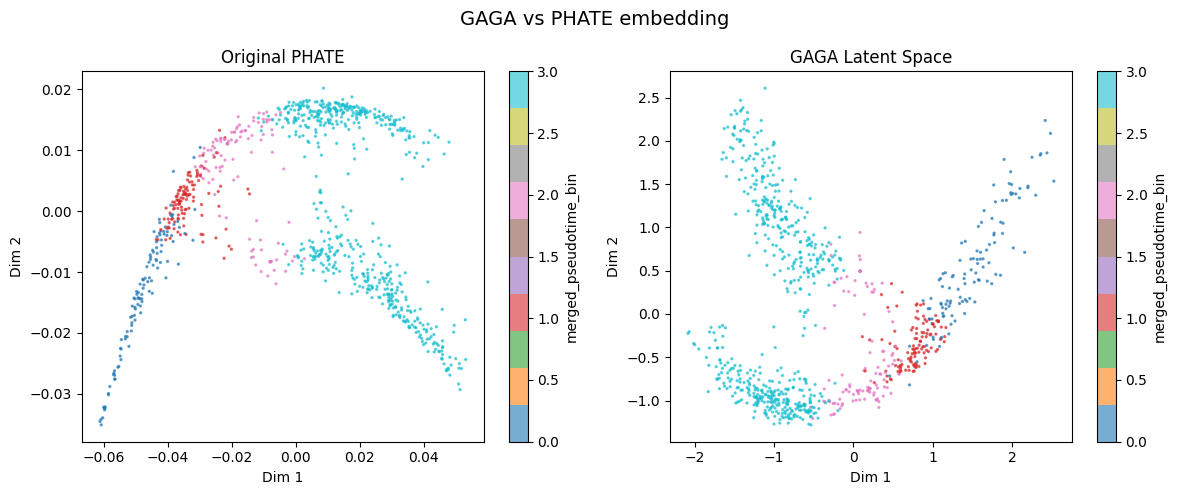

In [25]:
# ── Quick sanity-check: compare GAGA latent space with original PHATE ────────
gaga_model.eval()
with torch.no_grad():
    gaga_embeddings = gaga_model.encode(torch.tensor(X_pca)).numpy()

adata.obsm['X_gaga'] = gaga_embeddings

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, key, title in zip(
    axes,
    ['X_phate', 'X_gaga'],
    ['Original PHATE', 'GAGA Latent Space'],
):
    sc_plot = ax.scatter(
        adata.obsm[key][:, 0], adata.obsm[key][:, 1],
        c=adata.obs[time_column], cmap='tab10', s=2, alpha=0.6,
    )
    plt.colorbar(sc_plot, ax=ax, label=time_column)
    ax.set_title(title)
    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')

plt.suptitle('GAGA vs PHATE embedding', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Configure and Initialise MIOFlow

Pass the trained `gaga_model` and `scaler_pca` (the scaler fitted on `X_pca` before GAGA training).  
`MIOFlow` will use the encoder to embed cells into latent space for ODE training, and the decoder in `decode_to_gene_space()`.

In [26]:
import importlib

sys.path.insert(0, '../MIOFlow')
import mioflow
# After making changes to my_module:
importlib.reload(mioflow)


mioflow_model = mioflow.MIOFlow(
    adata,
    gaga_model=gaga_model,
    gaga_input_scaler=scaler_pca,    # fitted on X_pca — used for encode() and inverse_transform()
    obs_time_key=time_column,
    debug_level='info',
    hidden_dim = 64,
    use_cuda = torch.cuda.is_available(),
    momentum_beta = 0.0,
    scheduler_type='cosine',
    learning_rate = 1e-3,
    scheduler_t_max=300,
    scheduler_min_lr=1e-5,
    # Training phases
    n_epochs=300,
    # Loss
    use_density_loss=True,
    lambda_ot = [1.0,1.0,1.0,5.0],
    lambda_density=0.0,
    lambda_energy=0.1,
    energy_time_steps=20,
    # Data / output
    sample_size=100,
    n_trajectories=100,
    n_bins=100,
    exp_dir='.',
)



2026-02-25 15:52:35,482 - MIOFlow - INFO - MIOFlow initialised | 900 cells, 100 genes | device=cpu


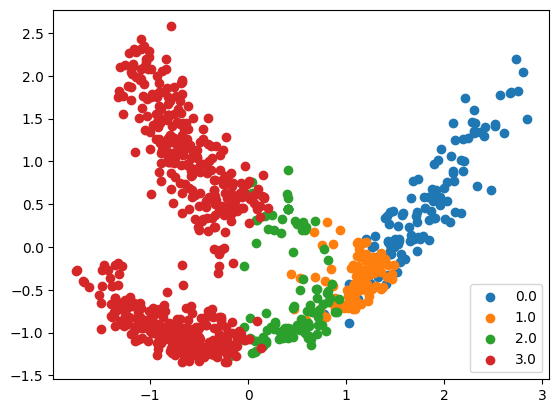

In [27]:
for data, i in mioflow_model.dataset.time_series_data:
    plt.scatter(data[:,0],data[:,1],label=i)
plt.legend()

## 4. Fit — `~5 minutes`

`fit()` runs three phases under the hood:
1. **Training** (`n_local_epochs`) — trains each consecutive time-point pair independently

The ODE operates entirely in the GAGA latent space.

In [28]:
mioflow_model.fit()
print(mioflow_model)

2026-02-25 15:52:35,729 - MIOFlow - INFO - ODEFunc: input_dim=2, hidden_dim=64
2026-02-25 15:52:35,729 - MIOFlow - INFO - Global training: 300 epochs
Training (global): 100%|██████████| 300/300 [00:36<00:00,  8.27it/s]
2026-02-25 15:53:12,042 - MIOFlow - INFO - Trajectories generated: shape=(100, 100, 2)
2026-02-25 15:53:12,043 - MIOFlow - INFO - MIOFlow fitting completed.


MIOFlow(n_obs=900, gaga=Autoencoder, n_epochs=300, trajectories=(100, 100, 2), status=fitted)


## 4. Training Losses

After fitting:
- `mf.losses` — list of dicts `{'Total', 'OT', 'Density', 'Energy'}` per epoch (local phase)

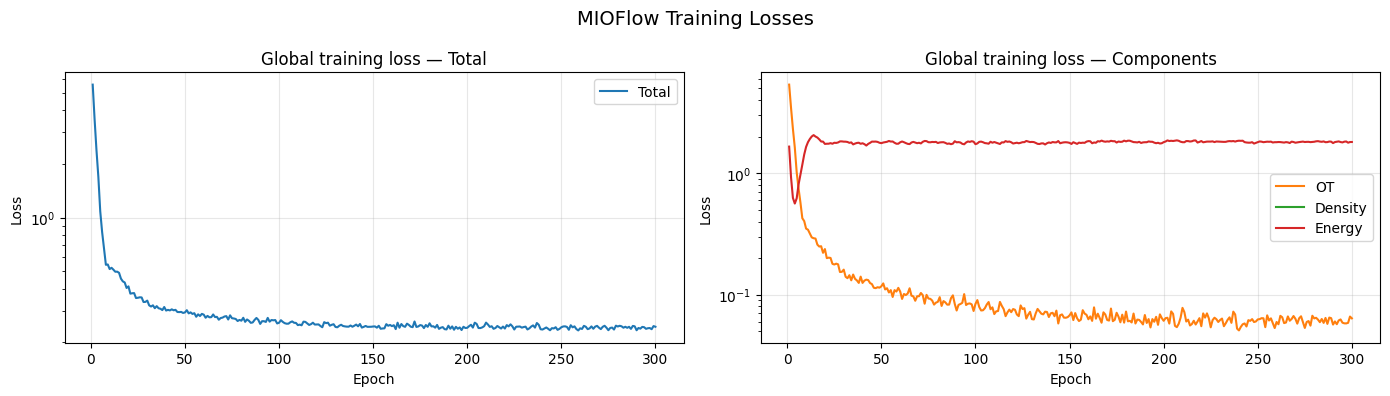

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# ── Losses ───────────────────────────────────────────────────────────
epochs = mioflow_model.losses['epoch']

# Left: total loss
ax = axes[0]
ax.plot(epochs, mioflow_model.losses['total_loss'], label='Total', color='tab:blue')
ax.set_title('Global training loss — Total')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: individual loss components
ax = axes[1]
ax.plot(epochs, mioflow_model.losses['ot_loss'],      label='OT',      color='tab:orange')
ax.plot(epochs, mioflow_model.losses['density_loss'], label='Density', color='tab:green')
ax.plot(epochs, mioflow_model.losses['energy_loss'],  label='Energy',  color='tab:red')
ax.set_title('Global training loss — Components')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('MIOFlow Training Losses', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Trajectories in GAGA Latent Space

`mf.trajectories` has shape **`(n_bins, n_trajectories, latent_dim)`**.

To iterate over individual trajectories use `mf.trajectories[:, i, :]`.

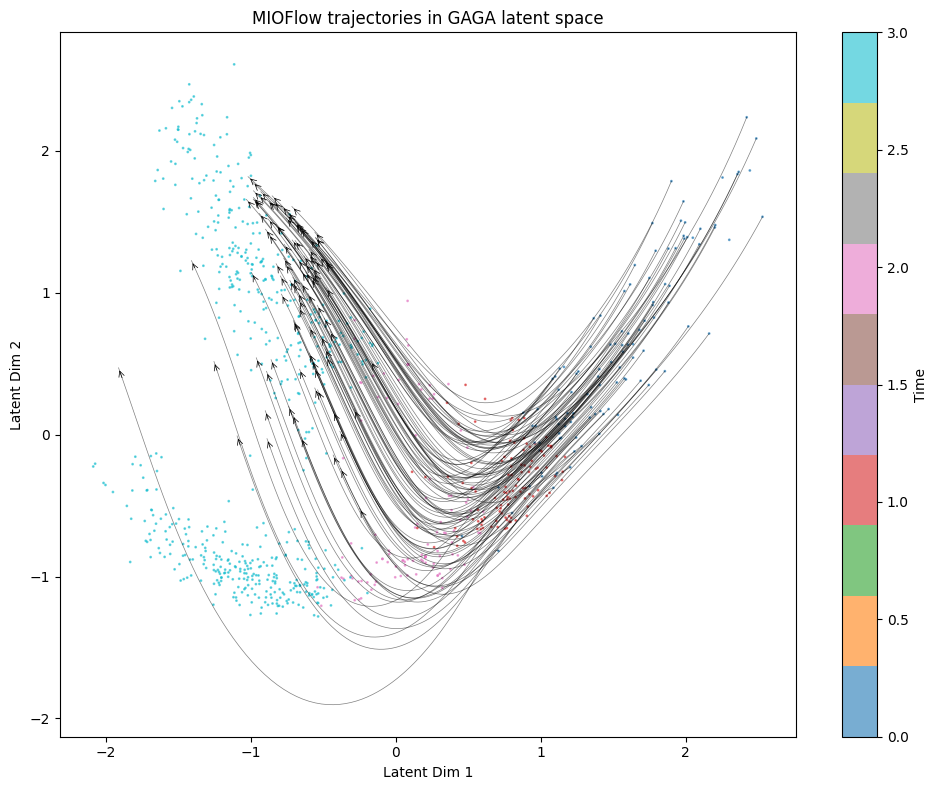

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sc_plot = ax.scatter(
    mioflow_model.embedding[:, 0], mioflow_model.embedding[:, 1],
    c=mioflow_model._time_labels, cmap='tab10', s=1, alpha=0.6,
)
plt.colorbar(sc_plot, ax=ax, label='Time')

for traj in mioflow_model.trajectories.transpose(1, 0, 2):  # (n_traj, n_bins, latent_dim)
    ax.plot(traj[:, 0], traj[:, 1], alpha=0.5, linewidth=0.5, color='black')
    ax.annotate(
        '', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
        arrowprops=dict(arrowstyle='->', color='black', lw=0.5, mutation_scale=10),
    )

ax.set_xlabel('Latent Dim 1')
ax.set_ylabel('Latent Dim 2')
ax.set_title('MIOFlow trajectories in GAGA latent space')
plt.tight_layout()
plt.show()


## 6. Decode to Gene Space

`decode_to_gene_space()` maps trajectories through the chain:

**GAGA latent → GAGA decoder → PCA space (inverse scaler) → gene space**

Returns shape **`(n_bins, n_trajectories, n_genes)`**.

In [31]:
trajectories_gene_space = mioflow_model.decode_to_gene_space()
print('Gene-space trajectory shape (n_bins, n_trajectories, n_genes):',
      trajectories_gene_space.shape)

Gene-space trajectory shape (n_bins, n_trajectories, n_genes): (100, 100, 100)


## 7. Gene Trends — Top Highly-Variable Genes

We plot the mean expression (± std) over all trajectories at each time bin.

In [32]:
sc.pp.highly_variable_genes(adata, n_top_genes=25)
example_genes     = adata.var_names[adata.var['highly_variable']]
example_gene_mask = adata.var_names.isin(example_genes)
print(example_genes)

Index(['G3', 'G6', 'G12', 'G14', 'G21', 'G25', 'G26', 'G31', 'G32', 'G33',
       'G36', 'G40', 'G49', 'G51', 'G59', 'G64', 'G65', 'G68', 'G69', 'G72',
       'G80', 'G88', 'G94', 'G95', 'G99'],
      dtype='object')


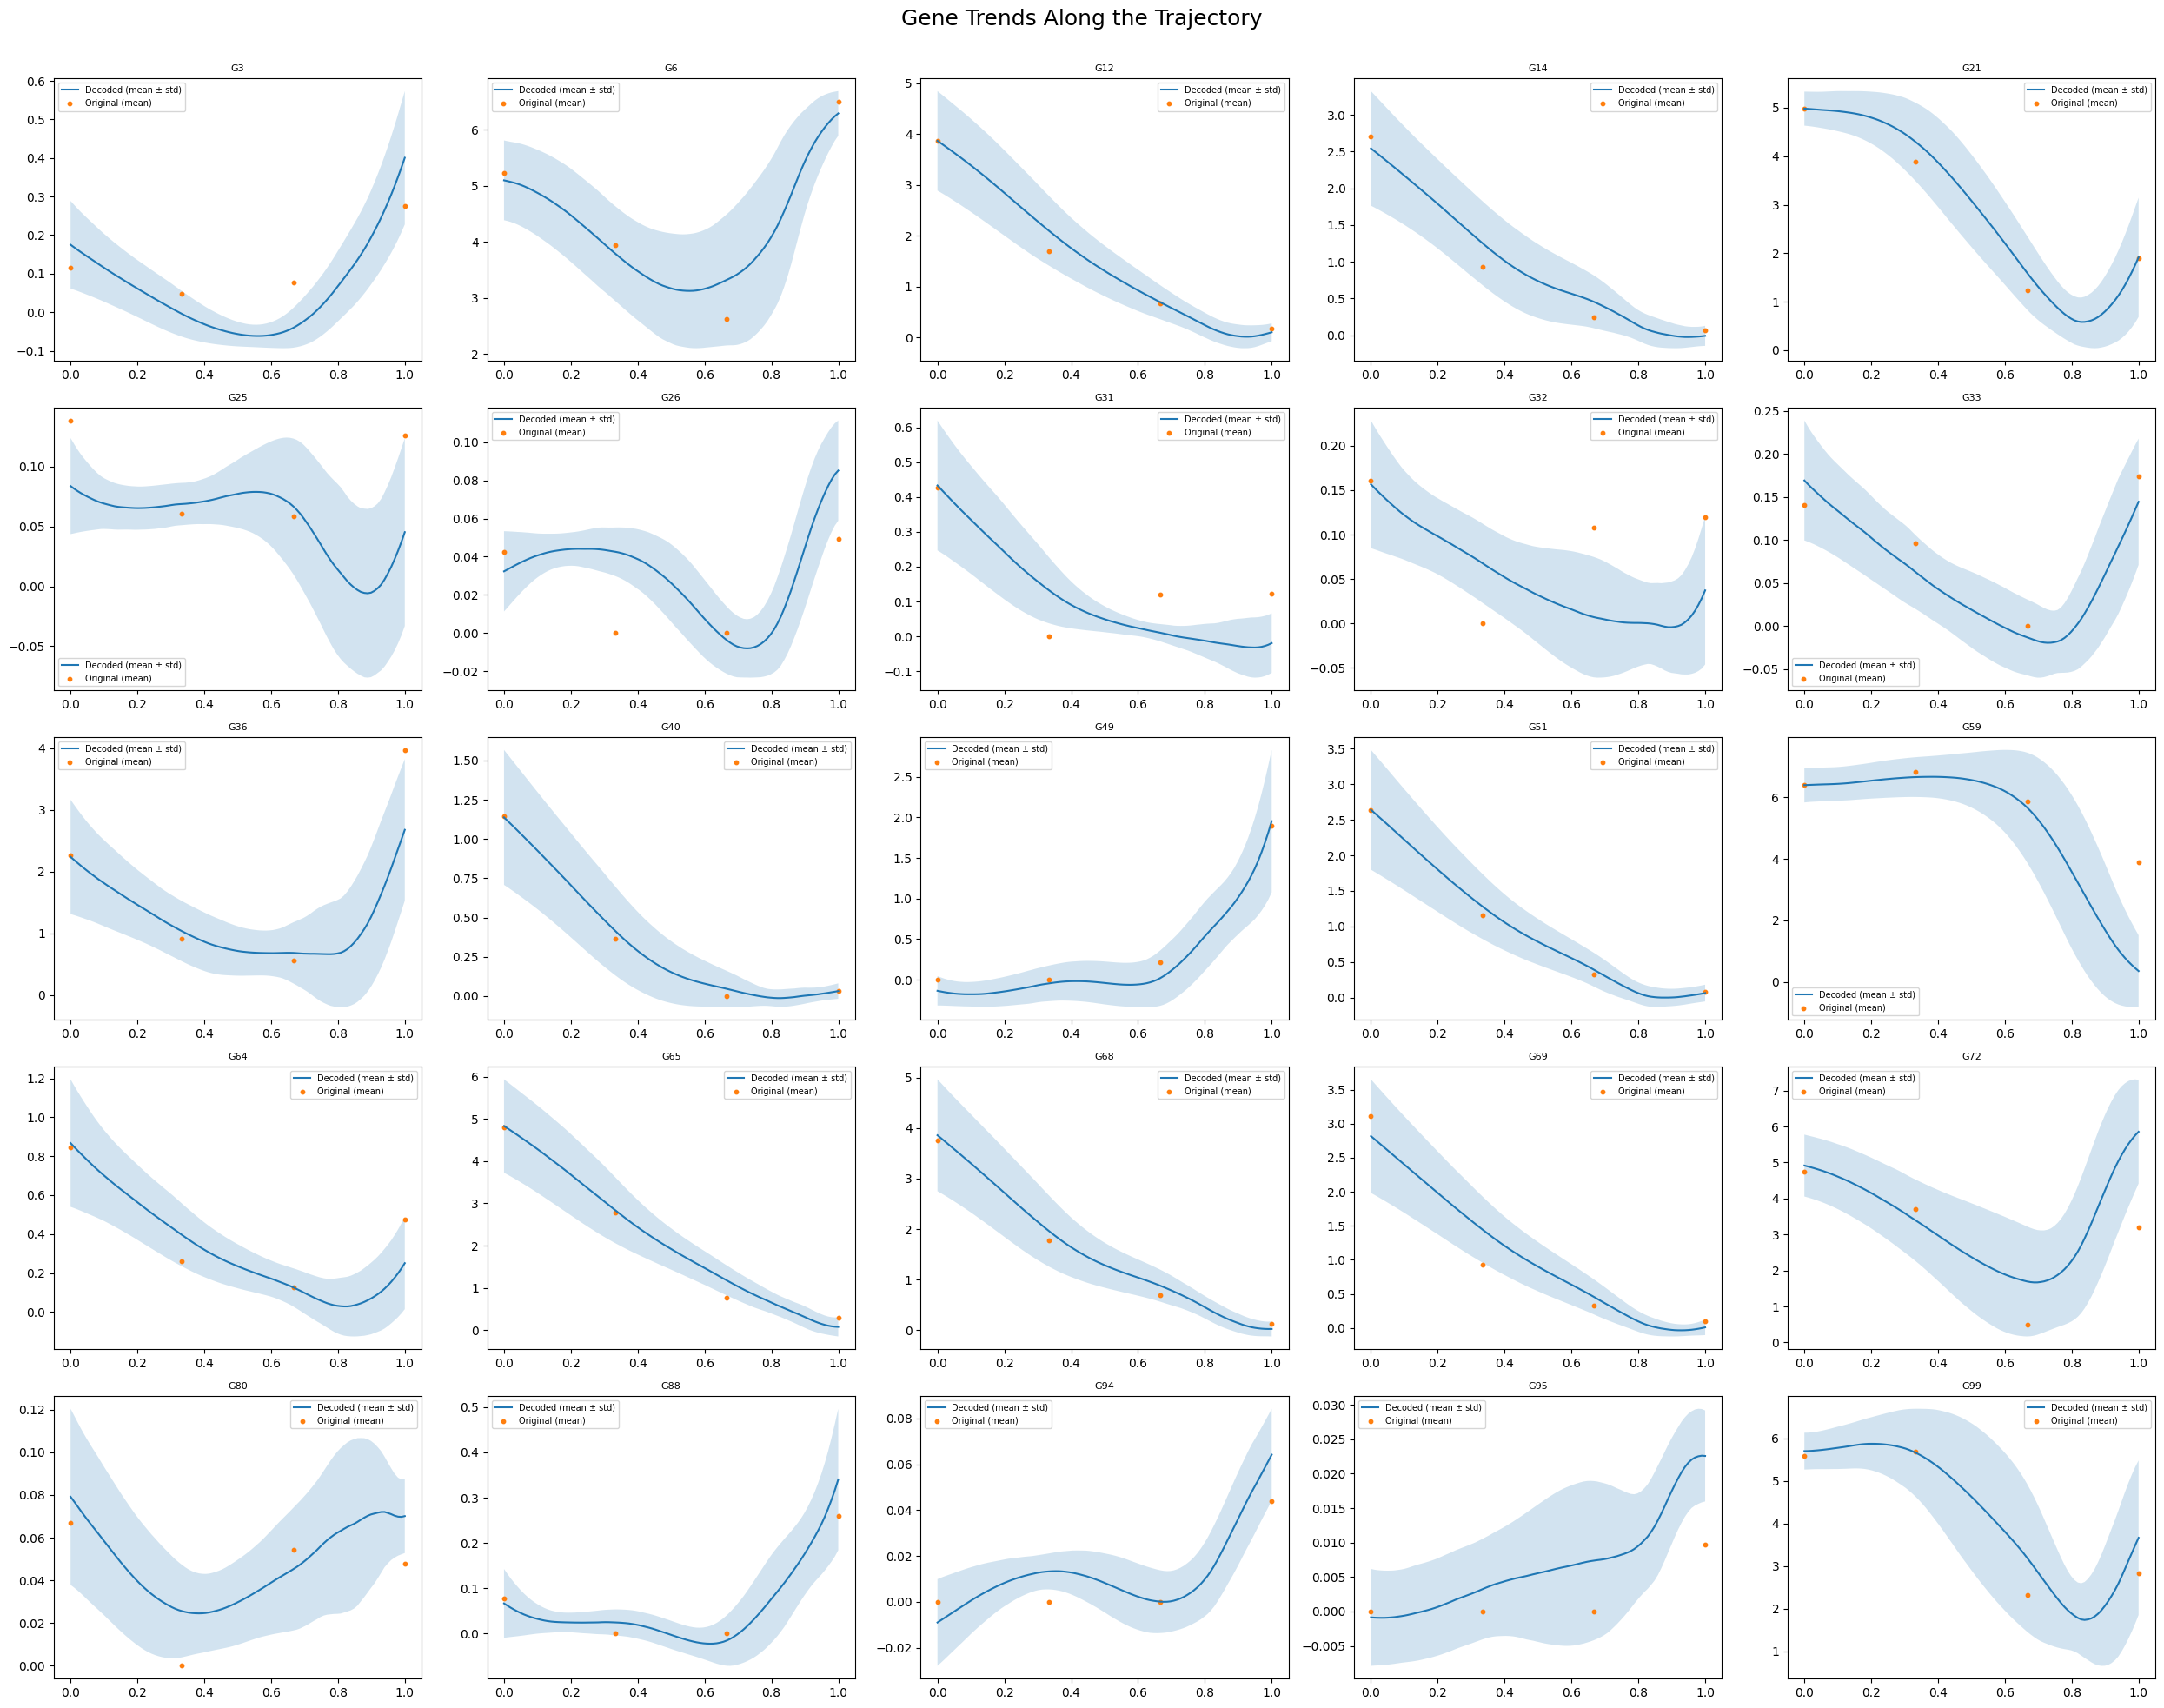

In [33]:
# decoded shape: (n_bins, n_trajectories, n_selected_genes)
decoded_example_gene = trajectories_gene_space[:, :, example_gene_mask]

# Mean / std over trajectories (axis=1) → (n_bins, n_selected_genes)
decoded_mean = decoded_example_gene.mean(axis=1)
decoded_std  = decoded_example_gene.std(axis=1)

# Normalised time axis
x_time = np.linspace(0, 1, decoded_mean.shape[0])

# Reconstruct integer time labels the same way MIOFlow does internally
t = mioflow_model._time_labels.astype(float)
obs_time_norm = (t - t.min()) / (t.max() - t.min())

# Original data aggregated by time
adata_sel = adata[:, example_gene_mask]
data_df   = pd.DataFrame(adata_sel.X.toarray(), columns=example_genes)
data_df['t'] = obs_time_norm
data_mean = data_df.groupby('t').mean()

# Grid plot
n_genes = decoded_mean.shape[1]
n_cols  = int(np.ceil(np.sqrt(n_genes)))
n_rows  = int(np.ceil(n_genes / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, gene in enumerate(example_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_mean[:, i], label='Decoded (mean ± std)')
    ax.fill_between(x_time,
                    decoded_mean[:, i] - decoded_std[:, i],
                    decoded_mean[:, i] + decoded_std[:, i],
                    alpha=0.2)
    ax.scatter(data_mean.index, data_mean[gene], s=10, label='Original (mean)')
    ax.set_title(gene, fontsize=8)
    ax.legend(fontsize=7)

for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.suptitle('Gene Trends Along the Trajectory', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()


## 8. Single Gene of Interest

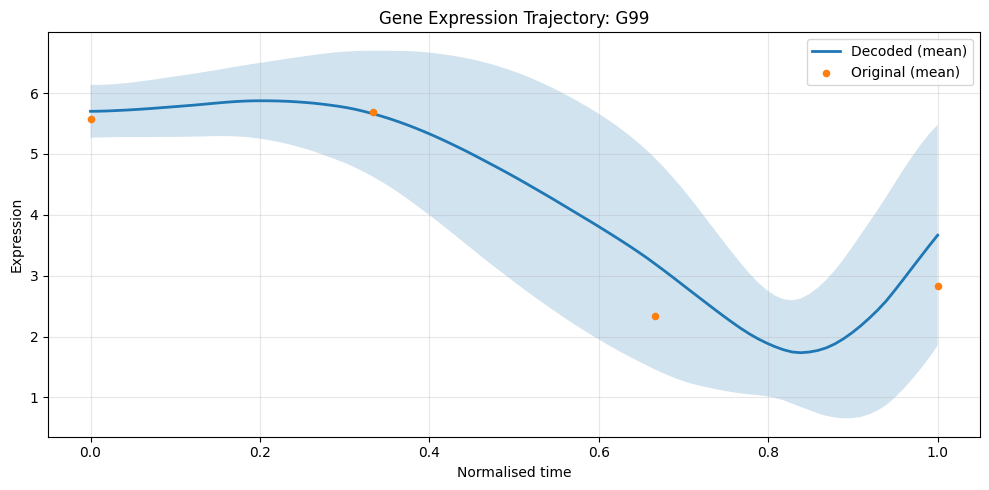

In [34]:
interest_gene = 'G99'

gene_mask = adata.var_names.isin([interest_gene])
gene_traj = trajectories_gene_space[:, :, gene_mask]  # (n_bins, n_traj, 1)
gene_mean = gene_traj.mean(axis=1).flatten()           # (n_bins,)
gene_std  = gene_traj.std(axis=1).flatten()

x_time_gene = np.linspace(0, 1, len(gene_mean))

orig_df = pd.DataFrame({
    'expression': adata[:, gene_mask].X.toarray().flatten(),
    'time':       obs_time_norm,
})
orig_mean = orig_df.groupby('time')['expression'].mean()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_time_gene, gene_mean, linewidth=2, label='Decoded (mean)')
ax.fill_between(x_time_gene, gene_mean - gene_std, gene_mean + gene_std, alpha=0.2)
ax.scatter(orig_mean.index, orig_mean.values, s=20, label='Original (mean)', zorder=3)
ax.set_xlabel('Normalised time')
ax.set_ylabel('Expression')
ax.set_title(f'Gene Expression Trajectory: {interest_gene}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Highlight a Specific Trajectory

Select the trajectory whose endpoint is closest to a target coordinate in latent space.

Selected trajectory 30 at endpoint (-1.0172, 1.8172)


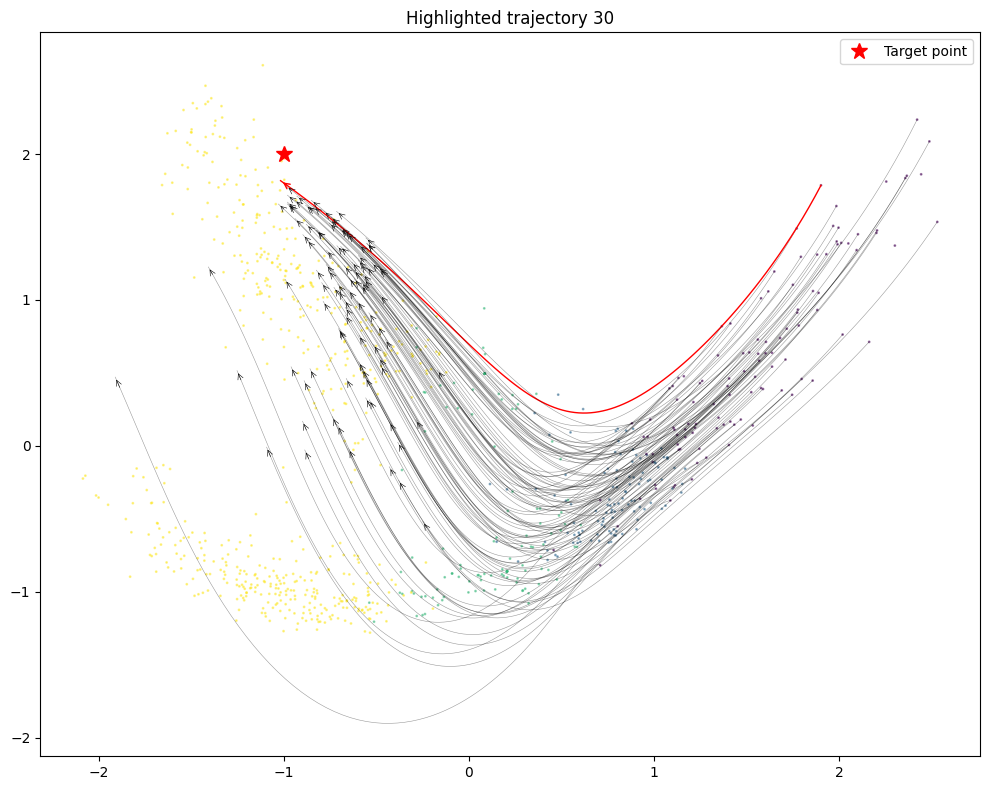

In [37]:
target_x, target_y = -1, 2

# Find closest trajectory endpoint: last time step across all trajectories
endpoints = mioflow_model.trajectories[-1, :, :]  # (n_traj, 2)
dists     = np.sqrt((endpoints[:, 0] - target_x)**2 + (endpoints[:, 1] - target_y)**2)
highlight = int(dists.argmin())
print(f'Selected trajectory {highlight} at endpoint '
      f'({endpoints[highlight, 0]:.4f}, {endpoints[highlight, 1]:.4f})')

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(mioflow_model.embedding[:, 0], mioflow_model.embedding[:, 1],
           c=mioflow_model._time_labels, cmap='viridis', s=1, alpha=0.5)

for i, traj in enumerate(mioflow_model.trajectories.transpose(1, 0, 2)):
    color = 'red'  if i == highlight else 'black'
    lw    = 1.0    if i == highlight else 0.4
    alpha = 1.0    if i == highlight else 0.4
    ax.plot(traj[:, 0], traj[:, 1], color=color, lw=lw, alpha=alpha)
    ax.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                arrowprops=dict(arrowstyle='->', color=color, lw=lw, mutation_scale=10))

ax.plot(target_x, target_y, 'r*', markersize=12, label='Target point')
ax.set_title(f'Highlighted trajectory {highlight}')
ax.legend()
plt.tight_layout()
plt.show()

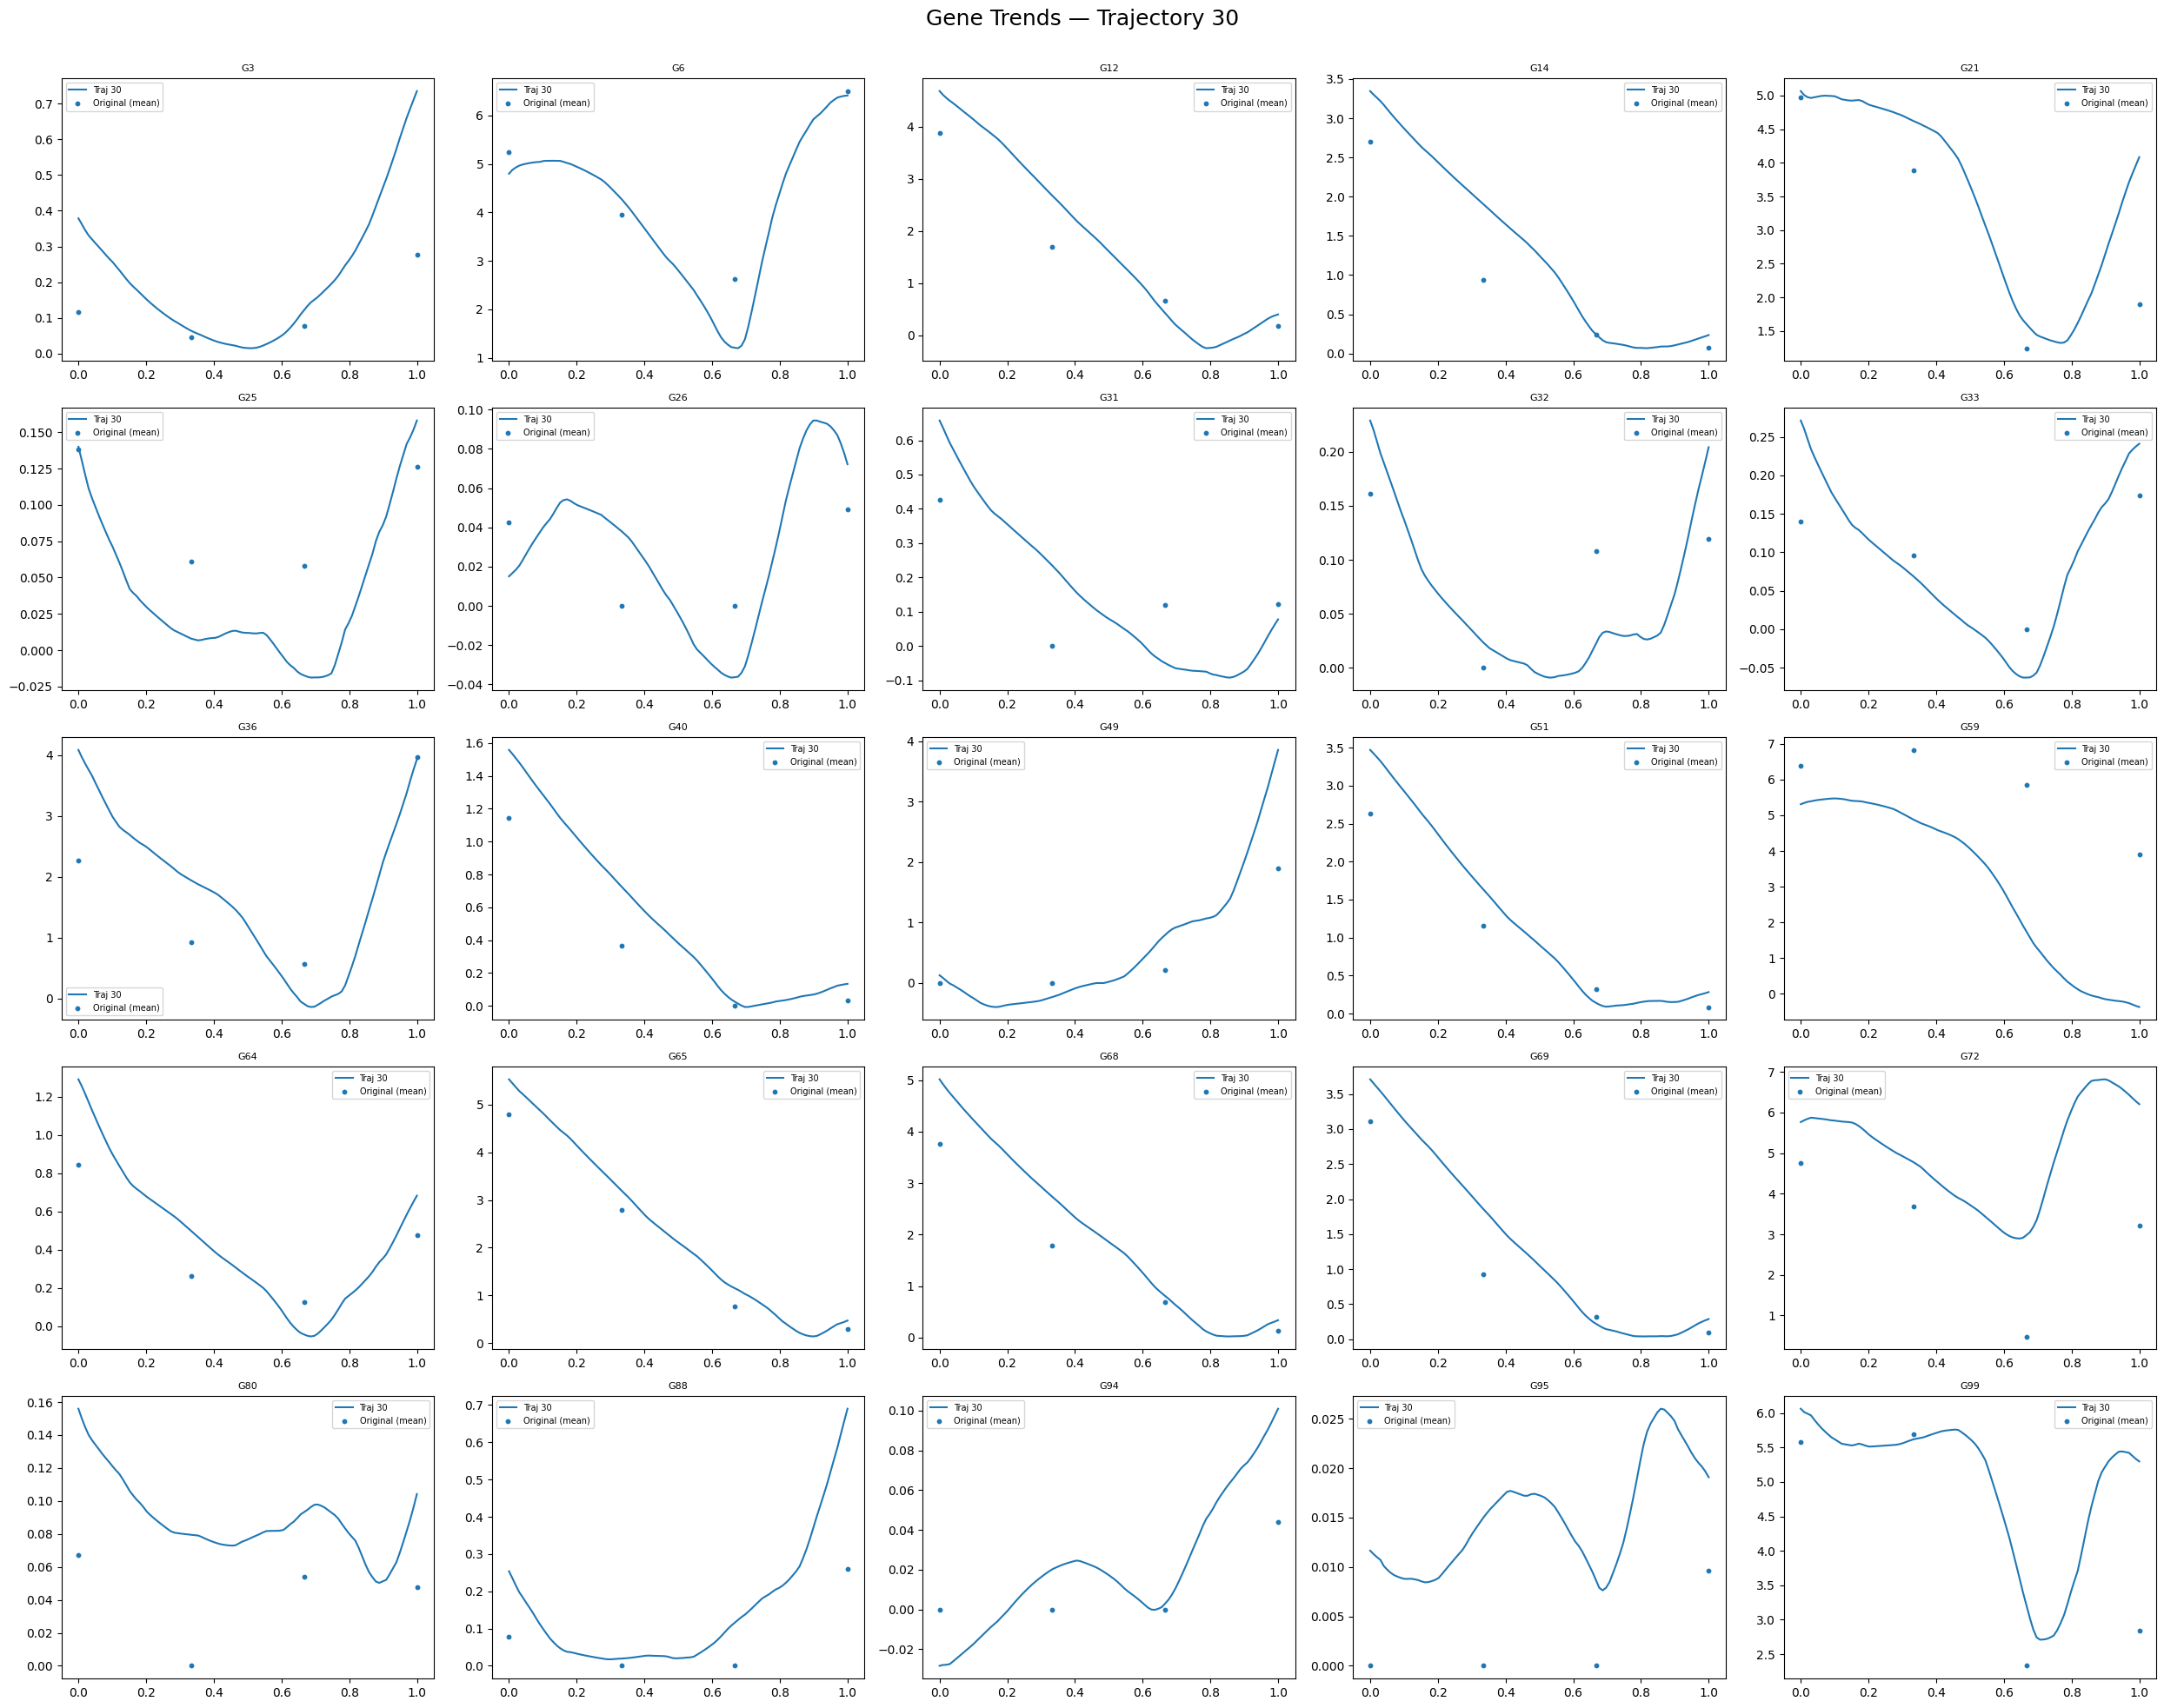

In [38]:
# Gene trends for the single highlighted trajectory
# decoded_example_gene shape: (n_bins, n_trajectories, n_selected_genes)
decoded_highlight = decoded_example_gene[:, highlight, :]  # (n_bins, n_selected_genes)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, gene in enumerate(example_genes):
    ax = axes[i]
    ax.plot(x_time, decoded_highlight[:, i], label=f'Traj {highlight}')
    ax.scatter(data_mean.index, data_mean[gene], s=10, label='Original (mean)')
    ax.set_title(gene, fontsize=8)
    ax.legend(fontsize=7)

for i in range(n_genes, len(axes)):
    axes[i].set_visible(False)

plt.suptitle(f'Gene Trends — Trajectory {highlight}', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()